# IDB_drilling_signal

## Import packages

In [1]:
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import scipy.io as scio
import seaborn as sns
import time
import visualkeras

from keras.layers import Activation, BatchNormalization, Concatenate, Conv1D, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling1D, GlobalAveragePooling2D, Input, MaxPooling1D, MaxPooling2D
from keras.models import load_model, Model, Sequential
from keras.utils.np_utils import to_categorical
from pyts.image import RecurrencePlot, MarkovTransitionField, GramianAngularField
from tensorflow import keras
from tqdm import tqdm

# import xgboost as xgb
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

!nvidia-smi

HOST_path = "/hpctmp/e1097232"

random.seed(42)

def nameof(var):
    for name, value in globals().items():
        if value is var:
            return name

Thu Jul  6 09:50:08 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB            Off| 00000000:1A:00.0 Off |                    0 |
| N/A   37C    P0               45W / 300W|      0MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load signal data

In [2]:
RATE = 8192

def read_matFile(signal_path):
    signal_file = scio.loadmat(signal_path)
    signal_value = signal_file['samples']
    signal_value = np.squeeze(signal_value)
    print("signal_shape:", signal_value.shape, "sampling_rate:", RATE, "time:", len(signal_value)/RATE, "s")
    max_value = np.max(np.abs(signal_value))
    signal_value_normalized = signal_value / max_value
    return signal_value_normalized

def read_allFile(signal_path):
    signal_value, signal_rate = librosa.load(signal_path, sr=None, mono=True, offset=0.0, duration=None)
    print("signal_shape:", signal_value.shape, "sampling_rate:", signal_rate, "time:", len(signal_value)/signal_rate, "s")
    if signal_rate != RATE:
        signal_value = librosa.resample(signal_value, orig_sr=signal_rate, target_sr=RATE)
    max_value = np.max(np.abs(signal_value))
    signal_value_normalized = signal_value / max_value
    return signal_value_normalized

# granite
G32h = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment1/matFile/3-2h.mat"))
G41h = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment1/matFile/4-1h.mat"))
G42h = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment1/matFile/4-2h.mat"))
G43b = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment1/matFile/4-3b.mat"))
# sandstone
S11 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/1-1.mat"))
S12 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/1-2.mat"))
S13 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/1-3.mat"))
S14 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/1-4.mat"))
S21 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/2-1.mat"))
S22 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/2-2.mat"))
S23 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/2-3.mat"))
S31 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/3-1.mat"))
S32 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/3-2.mat"))
S33 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/3-3.mat"))
S41 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/4-1.mat"))
S42 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/4-2.mat"))
S43 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/4-3.mat"))
S51 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/5-1.mat"))
S52 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/5-2.mat"))
S53 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/5-3.mat"))
S54 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/5-4.mat"))
S61 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/6-1.mat"))
S62 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/6-2.mat"))
S63 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/6-3.mat"))
S71 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/7-1.mat"))
S72 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/7-2.mat"))
S73 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/7-3.mat"))
S74 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/7-4.mat"))
S81 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/8-1.mat"))
S82 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/8-2.mat"))
S83 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/8-3.mat"))
S91 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/9-1.mat"))
S92 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/9-2.mat"))
S93 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/9-3.mat"))
S94 = read_matFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment2/matFile/9-4.mat"))
# basalt
B11 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/1-1.wav"))
B12 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/1-2.wav"))
B13 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/1-3.wav"))
B21 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/2-1.wav"))
B22 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/2-2.wav"))
B23 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/2-3.wav"))
B31 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/3-1.wav"))
B32 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/3-2.wav"))
B33 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/3-3.wav"))
B41 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/4-1.wav"))
B42 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/4-2.wav"))
B43 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/4-3.wav"))
B51 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/5-1.wav"))
B52 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/5-2.wav"))
B53 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/5-3.wav"))
B54 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/5-4.wav"))
B61 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/6-1.wav"))
B62 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/6-2.wav"))
B63 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/6-3.wav"))
B71 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/7-1.wav"))
B72 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/7-2.wav"))
B73 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/7-3.wav"))
B81 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/8-1.wav"))
B82 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/8-2.wav"))
B83 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/8-3.wav"))
B91 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/9-1.wav"))
B92 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/9-2.wav"))
B93 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal/Rock_drilling_signal/experiment3/waveFile/9-3.wav"))
print("------------------------------------")
print("All signal normalized with sr = 8192")

signal_shape: (8880128,) sampling_rate: 8192 time: 1084.0 s
signal_shape: (7216896,) sampling_rate: 8192 time: 880.96875 s
signal_shape: (11019776,) sampling_rate: 8192 time: 1345.1875 s
signal_shape: (22244352,) sampling_rate: 8192 time: 2715.375 s
signal_shape: (1248512,) sampling_rate: 8192 time: 152.40625 s
signal_shape: (3898112,) sampling_rate: 8192 time: 475.84375 s
signal_shape: (3248384,) sampling_rate: 8192 time: 396.53125 s
signal_shape: (1114368,) sampling_rate: 8192 time: 136.03125 s
signal_shape: (846336,) sampling_rate: 8192 time: 103.3125 s
signal_shape: (1461248,) sampling_rate: 8192 time: 178.375 s
signal_shape: (1584384,) sampling_rate: 8192 time: 193.40625 s
signal_shape: (727296,) sampling_rate: 8192 time: 88.78125 s
signal_shape: (1953536,) sampling_rate: 8192 time: 238.46875 s
signal_shape: (1200384,) sampling_rate: 8192 time: 146.53125 s
signal_shape: (354560,) sampling_rate: 8192 time: 43.28125 s
signal_shape: (1647872,) sampling_rate: 8192 time: 201.15625 s
si

## Plot signal data

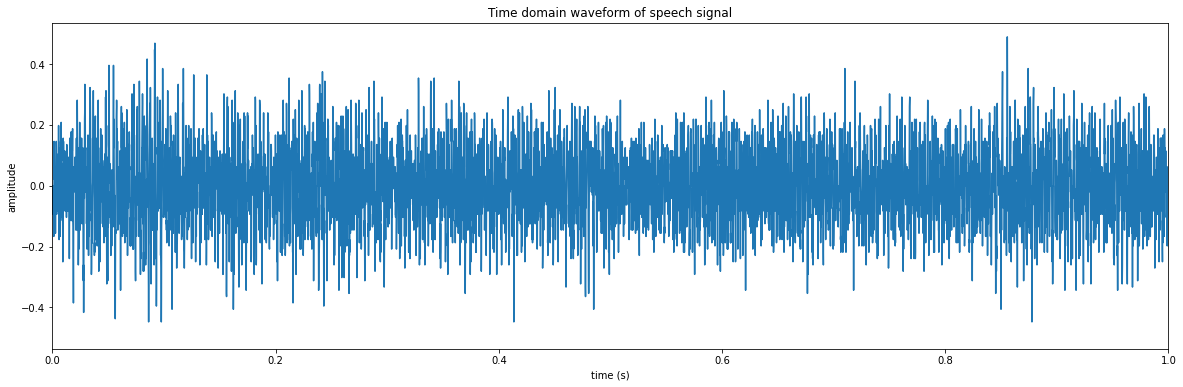

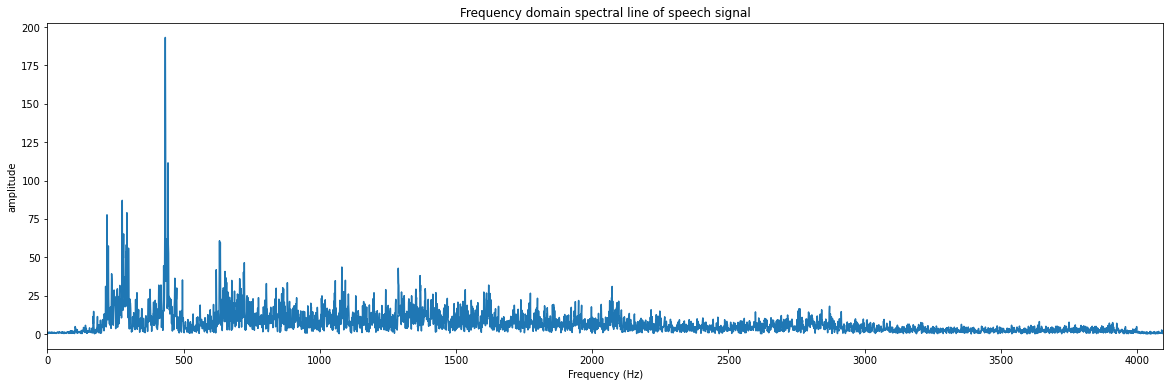

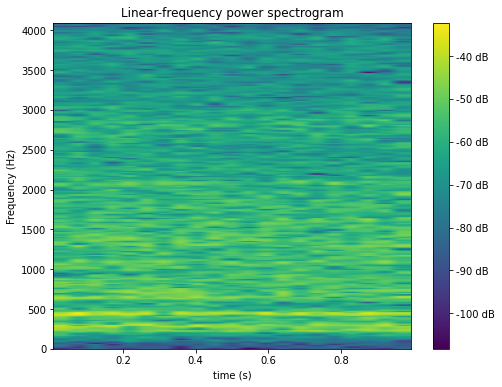

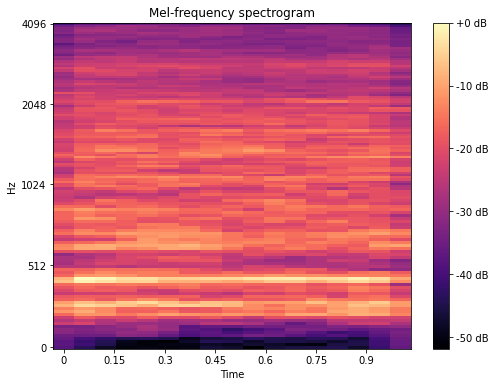

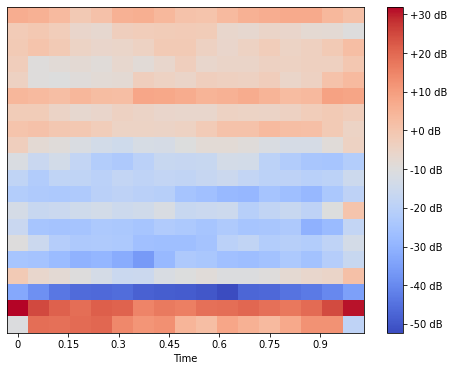

In [3]:
def displayWaveform(signal, rate):
  plt.figure(figsize=(20,6))
  max = np.max(np.absolute(signal))*1.2
  time = np.arange(0, len(SIGNAL)) / RATE
  plt.plot(time, signal)
  plt.title("Time domain waveform of speech signal")
  plt.xlabel("time (s)")
  plt.ylabel("amplitude")
  plt.xlim(0,len(SIGNAL)/RATE)
  ymin, ymax = plt.ylim()
  ylim = np.maximum(np.abs(ymin), np.abs(ymax))
  plt.ylim(-ylim, ylim)

def displaySpectrum(signal, rate):
  plt.figure(figsize=(20,6)) 
  s = np.fft.fft(signal)
  m = np.abs(s)
  n = len(signal)
  f = np.fft.fftfreq(n, 1/rate)
  plt.plot(f[:n//2],m[:n//2])
  plt.title("Frequency domain spectral line of speech signal")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("amplitude")
  plt.xlim(0, rate//2)

def displaySpectrogram(signal, rate, fftlen):    
  plt.figure(figsize=(8,6))
  plt.specgram(signal, NFFT=fftlen, Fs=rate, noverlap=int(fftlen*0.25), window=np.hanning(fftlen))
  plt.title('Linear-frequency power spectrogram')
  plt.xlabel('time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.colorbar(format="%+2.0f dB")
    
def displayMelspectrogram(signal, rate):
  plt.figure(figsize=(8,6))
  # melspectrogram = librosa.feature.melspectrogram(y=signal, sr=rate)
  D = np.abs(librosa.stft(signal))**2
  S = librosa.feature.melspectrogram(S=D, sr=rate)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, sr=rate, fmax=rate/2, x_axis='time', y_axis='mel') 
  plt.title('Mel-frequency spectrogram')
  plt.colorbar(format='%+2.0f dB')

def diaplayMFCC(signal, rate):
  plt.figure(figsize=(8,6))
  mfccs = librosa.feature.mfcc(y=signal, sr=rate)
  librosa.display.specshow(mfccs, sr=rate, x_axis='time')
  plt.colorbar(format='%+2.0f dB')

def displayZCR(signal, rate):
  plt.figure(figsize=(8,3))
  zcrs = librosa.feature.zero_crossing_rate(signal)  
  plt.plot(zcrs[0])

def normalize(x, axis=0):
    return preprocessing.minmax_scale(x, axis=axis)

def displayCentroids(signal, rate):
  cent = librosa.feature.spectral_centroid(y=signal, sr=rate) 
  S, phase = librosa.magphase(librosa.stft(y=signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_centroid(S=S)
  freqs, times, D = librosa.reassigned_spectrogram(signal, fill_nan=True)
  librosa.feature.spectral_centroid(S=np.abs(D), freq=freqs)
  times = librosa.times_like(cent)
  fig, ax = plt.subplots(nrows=2, sharex=True)
  ax[0].semilogy(times, cent[0], label='Spectral centroid')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()
  librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[1])
  ax[1].plot(times, cent.T, label='Spectral centroid', color='w')
  ax[1].set(title='log Power spectrogram')
  ax[1].legend(loc='lower right')

def displayBandwidth(signal, rate):
  spec_bw = librosa.feature.spectral_bandwidth(y=signal, sr=rate)
  S, phase = librosa.magphase(librosa.stft(y=signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_bandwidth(S=S)
  freqs, times, D = librosa.reassigned_spectrogram(signal, fill_nan=True)
  librosa.feature.spectral_bandwidth(S=np.abs(D), freq=freqs)
  times = librosa.times_like(spec_bw)
  centroid = librosa.feature.spectral_centroid(S=S)
  fig, ax = plt.subplots(nrows=2, sharex=True)
  ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
  ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
  ax[0].legend()
  ax[0].label_outer()
  librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax[1])
  ax[1].set(title='log Power spectrogram')
  ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]), np.minimum(centroid[0] + spec_bw[0], rate/2), alpha=0.5, label='Centroid +- bandwidth')
  ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
  ax[1].legend(loc='lower right')

def displayRolloff(signal, rate):
  librosa.feature.spectral_rolloff(y=signal, sr=rate)
  rolloff = librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.99)
  rolloff_min = librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.01)
  S, phase = librosa.magphase(librosa.stft(signal))
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  librosa.feature.spectral_rolloff(S=S, sr=rate)
  librosa.feature.spectral_rolloff(y=signal, sr=rate, roll_percent=0.95)
  fig, ax = plt.subplots()
  librosa.display.specshow(S_db, y_axis='log', x_axis='time', ax=ax)
  ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
  ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w', label='Roll-off frequency (0.01)')
  ax.legend(loc='lower right')
  ax.set(title='log Power spectrogram')

def displayChromastft(signal, rate, fftlen):
  S = np.abs(librosa.stft(signal))
  chroma = librosa.feature.chroma_stft(S=S, sr=rate)
  S = np.abs(librosa.stft(signal, n_fft=fftlen))**2
  S_db = librosa.amplitude_to_db(S, ref=np.max)
  chroma = librosa.feature.chroma_stft(S=S, sr=rate)
  fig, ax = plt.subplots(nrows=2, sharex=True)
  img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax[0])
  fig.colorbar(img, ax=[ax[0]])
  ax[0].label_outer()
  img = librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', ax=ax[1])
  fig.colorbar(img, ax=[ax[1]])

def displayChromacqt(signal, rate, n_chroma, n_fft):
  chroma_stft = librosa.feature.chroma_stft(y=signal, sr=rate, n_chroma=n_chroma, n_fft=n_fft)
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate)
  fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
  img1 = librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', ax=ax[0])
  ax[0].set(title='chroma_stft')
  ax[0].label_outer()
  img2 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[1])
  ax[1].set(title='chroma_cqt')
  fig.colorbar(img2, ax=ax)

def displayChromacens(signal, rate):
  chroma_cens = librosa.feature.chroma_cens(y=signal, sr=rate)
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate)
  fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
  img1 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[0])
  ax[0].set(title='chroma_cq')
  ax[0].label_outer()
  img2 = librosa.display.specshow(chroma_cens, x_axis='time', y_axis='chroma', ax=ax[1])
  ax[1].set(title='chroma_cens')
  fig.colorbar(img1, ax=ax)

def displayChromavqt(signal, rate, n_bins):
  chroma_cq = librosa.feature.chroma_cqt(y=signal, sr=rate, n_chroma=n_bins)
  chroma_vq = librosa.feature.chroma_vqt(y=signal, sr=rate, intervals='ji5', bins_per_octave=n_bins)
  fig, ax = plt.subplots(nrows=2, sharex=True)
  img1 = librosa.display.specshow(chroma_cq, x_axis='time', y_axis='chroma', ax=ax[0], bins_per_octave=n_bins)
  ax[0].set(ylabel='chroma_cqt')
  ax[0].label_outer()
  img2 = librosa.display.specshow(chroma_vq, y_axis='chroma_fjs', x_axis='time', ax=ax[1], bins_per_octave=n_bins, intervals='ji5')
  ax[1].set(ylabel='chroma_vqt')
  fig.colorbar(img2, ax=ax)

def plot_wave(signal, rate):  
  displayWaveform(signal, rate)
  displaySpectrum(signal, rate)
  displaySpectrogram(signal, rate, fftlen=512)
  displayMelspectrogram(signal, rate)
  diaplayMFCC(signal, rate)
#   displayZCR(signal, rate)
#   displayCentroids(signal, rate)
#   displayBandwidth(signal, rate)
#   displayRolloff(signal, rate)
#   displayChromastft(signal, rate, fftlen=512)
#   displayChromacqt(signal, rate, n_chroma=12, n_fft=512)
#   displayChromacens(signal, rate)
#   displayChromavqt(signal, rate, n_bins=24)

SIGNAL = G32h[0:RATE]
plot_wave(SIGNAL, RATE)
IPython.display.Audio(data=SIGNAL, rate=RATE)

## Cut signal data

In [4]:
G32h = G32h[0:1056*RATE]
G41h = G41h[120*RATE:840*RATE]
G42h = G42h[0:1260*RATE]
G43b = G43b[100*RATE:2240*RATE]

S11 = S11[0:150*RATE]
S12 = S12[210*RATE:416*RATE]
S13 = S13[140*RATE:374*RATE]
S14 = S14[2*RATE:136*RATE]
S21 = S21[0:103*RATE]
S22 = S22[0:156*RATE]
S23 = S23[42*RATE:126*RATE]
S31 = S31[0:86*RATE]
S32 = S32[76*RATE:213*RATE]
S33 = S33[33*RATE:130*RATE]
S41 = S41[0:41*RATE]
S42 = S42[100*RATE:123*RATE]
S43 = S43[115*RATE:135*RATE]
S51 = S51[3*RATE:28*RATE]
S52 = S52[103*RATE:126*RATE]
S53 = S53[126*RATE:153*RATE]
S54 = S54[157*RATE:181*RATE]
S61 = S61[40*RATE:57*RATE]
S62 = S62[128*RATE:150*RATE]
S63 = S63[35*RATE:51*RATE]
S71 = S71[16*RATE:88*RATE]
S72 = S72[86*RATE:328*RATE]
S73 = S73[116*RATE:260*RATE]
S74 = S74[112*RATE:286*RATE]
S81 = S81[0:78*RATE]
S82 = S82[84*RATE:189*RATE]
S83 = S83[130*RATE:312*RATE]
S91 = S91[0:45*RATE]
S92 = S92[50*RATE:108*RATE]
S93 = S93[72*RATE:228*RATE]
S94 = S94[68*RATE:258*RATE]

B11 = B11[4*RATE:484*RATE]
B12 = B12[4*RATE:382*RATE]
B13 = B13[0*RATE:280*RATE]
B21 = B21[4*RATE:157*RATE]
B22 = B22[4*RATE:170*RATE]
B23 = B23[8*RATE:166*RATE]
B31 = B31[15*RATE:146*RATE]
B32 = B32[12*RATE:258*RATE]
B33 = B33[12*RATE:177*RATE]
B41 = B41[10*RATE:109*RATE]
B42 = B42[6*RATE:64*RATE]
B43 = B43[6*RATE:88*RATE]
B51 = B51[8*RATE:78*RATE]
B52 = B52[4*RATE:268*RATE]
B53 = B53[8*RATE:97*RATE]
B54 = B54[4*RATE:123*RATE]
B61 = B61[4*RATE:205*RATE]
B62 = B62[4*RATE:135*RATE]
B63 = B63[6*RATE:124*RATE]
B71 = B71[4*RATE:296*RATE]
B72 = B72[4*RATE:204*RATE]
B73 = B73[10*RATE:303*RATE]
B81 = B81[6*RATE:182*RATE]
B82 = B82[6*RATE:183*RATE]
B83 = B83[10*RATE:219*RATE]
B91 = B91[4*RATE:201*RATE]
B92 = B92[6*RATE:138*RATE]
B93 = B93[0*RATE:158*RATE]
 
signals_list = ["G32h", "G41h", "G42h", "G43b",
              "S11", "S12", "S13", "S14", "S21", "S22", "S23", "S31", "S32", "S33",
              "S41", "S42", "S43", "S51", "S52", "S53", "S54", "S61", "S62", "S63",
              "S71", "S72", "S73", "S74", "S81", "S82", "S83", "S91", "S92", "S93", "S94",
              "B11", "B12", "B13", "B21", "B22", "B23", "B31", "B32", "B33",
              "B41", "B42", "B43", "B51", "B52", "B53", "B54", "B61", "B62", "B63", 
              "B71", "B72", "B73", "B81", "B82", "B83", "B91", "B92", "B93"]

def check_all():
    for signals in signals_list:
        print(signals, eval(signals).shape)
check_all()

G32h (8650752,)
G41h (5898240,)
G42h (10321920,)
G43b (17530880,)
S11 (1228800,)
S12 (1687552,)
S13 (1916928,)
S14 (1097728,)
S21 (843776,)
S22 (1277952,)
S23 (688128,)
S31 (704512,)
S32 (1122304,)
S33 (794624,)
S41 (335872,)
S42 (188416,)
S43 (163840,)
S51 (204800,)
S52 (188416,)
S53 (221184,)
S54 (196608,)
S61 (139264,)
S62 (180224,)
S63 (131072,)
S71 (589824,)
S72 (1982464,)
S73 (1179648,)
S74 (1425408,)
S81 (638976,)
S82 (860160,)
S83 (1490944,)
S91 (368640,)
S92 (475136,)
S93 (1277952,)
S94 (1556480,)
B11 (3932160,)
B12 (3096576,)
B13 (2293760,)
B21 (1253376,)
B22 (1359872,)
B23 (1294336,)
B31 (1073152,)
B32 (2015232,)
B33 (1351680,)
B41 (811008,)
B42 (475136,)
B43 (671744,)
B51 (573440,)
B52 (2162688,)
B53 (729088,)
B54 (974848,)
B61 (1646592,)
B62 (1073152,)
B63 (966656,)
B71 (2392064,)
B72 (1638400,)
B73 (2400256,)
B81 (1441792,)
B82 (1449984,)
B83 (1712128,)
B91 (1613824,)
B92 (1081344,)
B93 (1294336,)


## Pick signal data

In [5]:
def pick_signal(signals):
  sample_size = int(RATE)        # int(RATE/2)
  sample_step = int(sample_size/2) # int(RATE/4)
  sample_data = []
  for i in tqdm(range((len(signals)-sample_size) // sample_step)):
    sample_data.append(signals[i*sample_step : (i*sample_step+sample_size)])
  sample_data = np.stack(sample_data)
  sample_data = np.squeeze(sample_data)
  return sample_data

G32h = pick_signal(G32h)
G41h = pick_signal(G41h)
G42h = pick_signal(G42h)
G43b = pick_signal(G43b)

S11 = pick_signal(S11)
S12 = pick_signal(S12)
S13 = pick_signal(S13)
S14 = pick_signal(S14)
S21 = pick_signal(S21)
S22 = pick_signal(S22)
S23 = pick_signal(S23)
S31 = pick_signal(S31)
S32 = pick_signal(S32)
S33 = pick_signal(S33)
S41 = pick_signal(S41)
S42 = pick_signal(S42)
S43 = pick_signal(S43)
S51 = pick_signal(S51)
S52 = pick_signal(S52)
S53 = pick_signal(S53)
S54 = pick_signal(S54)
S61 = pick_signal(S61)
S62 = pick_signal(S62)
S63 = pick_signal(S63)
S71 = pick_signal(S71)
S72 = pick_signal(S72)
S73 = pick_signal(S73)
S74 = pick_signal(S74)
S81 = pick_signal(S81)
S82 = pick_signal(S82)
S83 = pick_signal(S83)
S91 = pick_signal(S91)
S92 = pick_signal(S92)
S93 = pick_signal(S93)
S94 = pick_signal(S94)

B11 = pick_signal(B11)
B12 = pick_signal(B12)
B13 = pick_signal(B13)
B21 = pick_signal(B21)
B22 = pick_signal(B22)
B23 = pick_signal(B23)
B31 = pick_signal(B31)
B32 = pick_signal(B32)
B33 = pick_signal(B33)
B41 = pick_signal(B41)
B42 = pick_signal(B42)
B43 = pick_signal(B43)
B51 = pick_signal(B51)
B52 = pick_signal(B52)
B53 = pick_signal(B53)
B54 = pick_signal(B54)
B61 = pick_signal(B61)
B62 = pick_signal(B62)
B63 = pick_signal(B63)
B71 = pick_signal(B71)
B72 = pick_signal(B72)
B73 = pick_signal(B73)
B81 = pick_signal(B81)
B82 = pick_signal(B82)
B83 = pick_signal(B83)
B91 = pick_signal(B91)
B92 = pick_signal(B92)
B93 = pick_signal(B93)

check_all()

100%|██████████████████████████████████████████████████████| 314/314 [00:00<00:00, 1692816.78it/s]

G32h (2110, 8192)
G41h (1438, 8192)
G42h (2518, 8192)
G43b (4278, 8192)
S11 (298, 8192)
S12 (410, 8192)
S13 (466, 8192)
S14 (266, 8192)
S21 (204, 8192)
S22 (310, 8192)
S23 (166, 8192)
S31 (170, 8192)
S32 (272, 8192)
S33 (192, 8192)
S41 (80, 8192)
S42 (44, 8192)
S43 (38, 8192)
S51 (48, 8192)
S52 (44, 8192)
S53 (52, 8192)
S54 (46, 8192)
S61 (32, 8192)
S62 (42, 8192)
S63 (30, 8192)
S71 (142, 8192)
S72 (482, 8192)
S73 (286, 8192)
S74 (346, 8192)
S81 (154, 8192)
S82 (208, 8192)
S83 (362, 8192)
S91 (88, 8192)
S92 (114, 8192)
S93 (310, 8192)
S94 (378, 8192)
B11 (958, 8192)
B12 (754, 8192)
B13 (558, 8192)
B21 (304, 8192)
B22 (330, 8192)
B23 (314, 8192)
B31 (260, 8192)
B32 (490, 8192)
B33 (328, 8192)
B41 (196, 8192)
B42 (114, 8192)
B43 (162, 8192)
B51 (138, 8192)
B52 (526, 8192)
B53 (176, 8192)
B54 (236, 8192)
B61 (400, 8192)
B62 (260, 8192)
B63 (234, 8192)
B71 (582, 8192)
B72 (398, 8192)
B73 (584, 8192)
B81 (350, 8192)
B82 (352, 8192)
B83 (416, 8192)
B91 (392, 8192)
B92 (262, 8192)
B93 (314, 8

## Convert signal data

signal shape:  (8192,)
waveform:  (8192,)
spectrum:  (4096,)
spectrogram_db:  (1025, 17)
mfccs:  (20, 17)


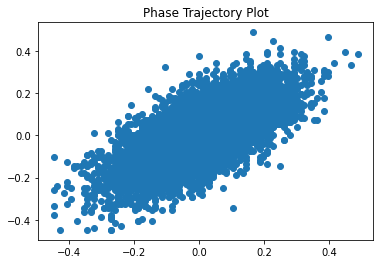

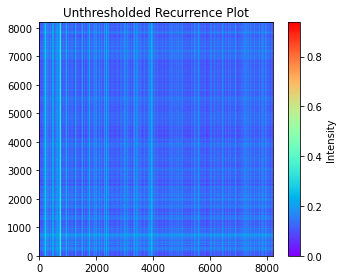

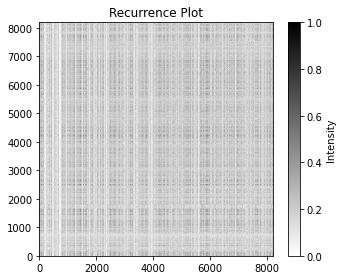

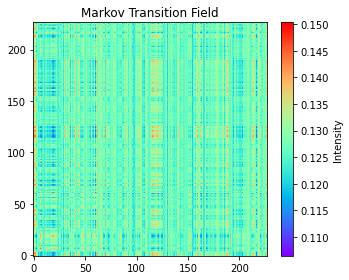

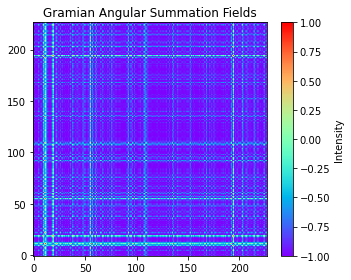

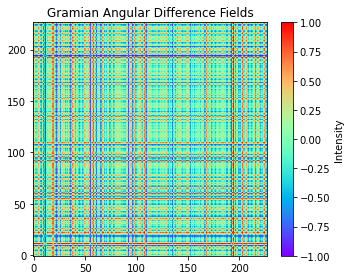

signal shape:  (227,)
waveform:  (227,)
spectrum:  (113,)
spectrogram_db:  (1025, 1)
mfccs:  (20, 1)


/home/svu/e1097232/.local/lib/python3.8/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=227
  warnings.warn(


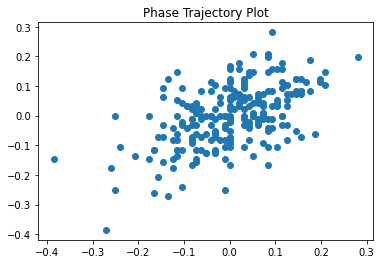

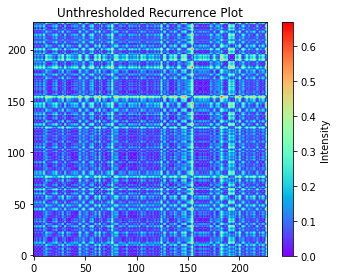

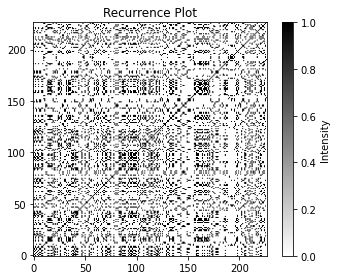

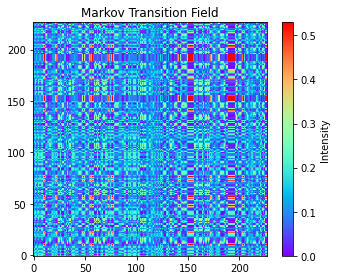

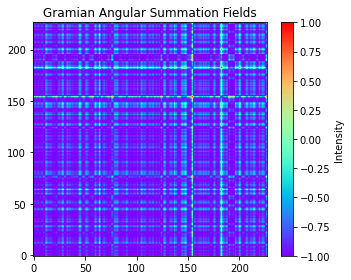

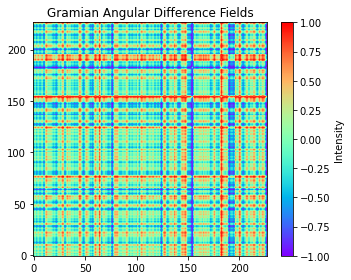

array([[ 0.        , -0.15625   ,  0.        , ...,  0.16023708,
        -0.3982178 , -0.84413782],
       [ 0.15625   ,  0.        ,  0.15625   , ...,  0.3125    ,
        -0.25      , -0.75      ],
       [ 0.        , -0.15625   ,  0.        , ...,  0.16023708,
        -0.3982178 , -0.84413782],
       ...,
       [-0.16023708, -0.3125    , -0.16023708, ...,  0.        ,
        -0.54005626, -0.91913764],
       [ 0.3982178 ,  0.25      ,  0.3982178 , ...,  0.54005626,
         0.        , -0.56082492],
       [ 0.84413782,  0.75      ,  0.84413782, ...,  0.91913764,
         0.56082492,  0.        ]])

In [6]:
# 1D original
def wave2wave(X, show):
    if show==1:
        print("waveform: ", X.shape)
    return X

# 1D spectrum
def wave2spectrum(X, show):
    spectrum = np.abs(np.fft.fft(X))
    spectrum = spectrum[0:len(spectrum)//2]
    if show==1:
        print("spectrum: ", spectrum.shape)
    return spectrum

# 2D spectrogram
def wave2spectrogram(X, show):
    spectrogram = np.abs(librosa.stft(X))
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    if show==1:
        print("spectrogram_db: ", spectrogram_db.shape)
    return spectrogram_db

# 2D mfcc
def wave2mfcc(X, show):
    mfccs = librosa.feature.mfcc(y=X, sr=RATE)
    if show==1:
         print("mfccs: ", mfccs.shape)
    return mfccs

# 2D ptp
def wave2ptp(X, show):
    autocorr = np.correlate(X, X, mode='full')
    time_delay = np.argmax(autocorr[len(autocorr)//2:]) + 1
    embedding = np.array([X[:-2*time_delay], X[time_delay:-time_delay]]).T
    if show==1:
        plt.scatter(embedding[:, 0], embedding[:, 1])
        plt.title('Phase Trajectory Plot')
        plt.show()
    return embedding

# 2D urp
def wave2urp(X, show):
    urp = RecurrencePlot(threshold=None)
    X_urp = urp.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_urp, cmap='rainbow', origin='lower')
        plt.title('Unthresholded Recurrence Plot')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_urp

# 2D rp
def wave2rp(X, show):
    rp = RecurrencePlot(threshold='point', percentage=20)
    X_rp = rp.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_rp, cmap='binary', origin='lower')
        plt.title('Recurrence Plot')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_rp

#2D mtf
def wave2mtf(X, show):
    mtf = MarkovTransitionField(image_size=227)
    X_mtf = mtf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_mtf, cmap='rainbow', origin='lower')
        plt.title('Markov Transition Field')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_mtf

# 2D ga(s)f
def wave2gasf(X, show):
    gasf = GramianAngularField(image_size=227, method='summation')
    X_gasf = gasf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_gasf, cmap='rainbow', origin='lower')
        plt.title('Gramian Angular Summation Fields')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_gasf

# 2D ga(d)f
def wave2gadf(X, show):
    gadf = GramianAngularField(image_size=227, method='difference')
    X_gadf = gadf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_gadf, cmap='rainbow', origin='lower')
        plt.title('Gramian Angular Difference Fields')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_gadf

# SIGNAL = G32h[0]
print("signal shape: ", SIGNAL.shape)
wave2wave(SIGNAL, 1)
wave2spectrum(SIGNAL, 1)
wave2spectrogram(SIGNAL, 1)
wave2mfcc(SIGNAL, 1)
wave2ptp(SIGNAL, 1)
wave2urp(SIGNAL, 1)
wave2rp(SIGNAL, 1)
wave2mtf(SIGNAL, 1)
wave2gasf(SIGNAL, 1)
wave2gadf(SIGNAL, 1)
SIGNAL = SIGNAL[0:227]
print("signal shape: ", SIGNAL.shape)
wave2wave(SIGNAL, 1)
wave2spectrum(SIGNAL, 1)
wave2spectrogram(SIGNAL, 1)
wave2mfcc(SIGNAL, 1)
wave2ptp(SIGNAL, 1)
wave2urp(SIGNAL, 1)
wave2rp(SIGNAL, 1)
wave2mtf(SIGNAL, 1)
wave2gasf(SIGNAL, 1)
wave2gadf(SIGNAL, 1)

In [7]:
def wave2others(signals):
    function = wave2spectrum
    results = []
    if function == wave2rp or function == wave2urp:
        random.seed(42)
        shorter_length = 227
        for signal in tqdm(signals):
            shorter_arrays = [signal[i:i+shorter_length] for i in range(len(signal) - shorter_length + 1)]
            signal = random.choice(shorter_arrays)
            result = wave2spectrum(signal, 0)
            result = function(signal, 0)
            results.append(result)
    else:
        for signal in tqdm(signals):
            result = wave2spectrum(signal, 0)
            result = function(signal, 0)
            results.append(result)
    results = np.array(results)
    return results

G32h = wave2others(G32h)
G41h = wave2others(G41h)
G42h = wave2others(G42h)
G43b = wave2others(G43b)

S11 = wave2others(S11)
S12 = wave2others(S12)
S13 = wave2others(S13)
S14 = wave2others(S14)
S21 = wave2others(S21)
S22 = wave2others(S22)
S23 = wave2others(S23)
S31 = wave2others(S31)
S32 = wave2others(S32)
S33 = wave2others(S33)
S41 = wave2others(S41)
S42 = wave2others(S42)
S43 = wave2others(S43)
S51 = wave2others(S51)
S52 = wave2others(S52)
S53 = wave2others(S53)
S54 = wave2others(S54)
S61 = wave2others(S61)
S62 = wave2others(S62)
S63 = wave2others(S63)
S71 = wave2others(S71)
S72 = wave2others(S72)
S73 = wave2others(S73)
S74 = wave2others(S74)
S81 = wave2others(S81)
S82 = wave2others(S82)
S83 = wave2others(S83)
S91 = wave2others(S91)
S92 = wave2others(S92)
S93 = wave2others(S93)
S94 = wave2others(S94)

B11 = wave2others(B11)
B12 = wave2others(B12)
B13 = wave2others(B13)
B21 = wave2others(B21)
B22 = wave2others(B22)
B23 = wave2others(B23)
B31 = wave2others(B31)
B32 = wave2others(B32)
B33 = wave2others(B33)
B41 = wave2others(B41)
B42 = wave2others(B42)
B43 = wave2others(B43)
B51 = wave2others(B51)
B52 = wave2others(B52)
B53 = wave2others(B53)
B54 = wave2others(B54)
B61 = wave2others(B61)
B62 = wave2others(B62)
B63 = wave2others(B63)
B71 = wave2others(B71)
B72 = wave2others(B72)
B73 = wave2others(B73)
B81 = wave2others(B81)
B82 = wave2others(B82)
B83 = wave2others(B83)
B91 = wave2others(B91)
B92 = wave2others(B92)
B93 = wave2others(B93)

check_all()

100%|█████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 4163.05it/s]

G32h (2110, 4096)
G41h (1438, 4096)
G42h (2518, 4096)
G43b (4278, 4096)
S11 (298, 4096)
S12 (410, 4096)
S13 (466, 4096)
S14 (266, 4096)
S21 (204, 4096)
S22 (310, 4096)
S23 (166, 4096)
S31 (170, 4096)
S32 (272, 4096)
S33 (192, 4096)
S41 (80, 4096)
S42 (44, 4096)
S43 (38, 4096)
S51 (48, 4096)
S52 (44, 4096)
S53 (52, 4096)
S54 (46, 4096)
S61 (32, 4096)
S62 (42, 4096)
S63 (30, 4096)
S71 (142, 4096)
S72 (482, 4096)
S73 (286, 4096)
S74 (346, 4096)
S81 (154, 4096)
S82 (208, 4096)
S83 (362, 4096)
S91 (88, 4096)
S92 (114, 4096)
S93 (310, 4096)
S94 (378, 4096)
B11 (958, 4096)
B12 (754, 4096)
B13 (558, 4096)
B21 (304, 4096)
B22 (330, 4096)
B23 (314, 4096)
B31 (260, 4096)
B32 (490, 4096)
B33 (328, 4096)
B41 (196, 4096)
B42 (114, 4096)
B43 (162, 4096)
B51 (138, 4096)
B52 (526, 4096)
B53 (176, 4096)
B54 (236, 4096)
B61 (400, 4096)
B62 (260, 4096)
B63 (234, 4096)
B71 (582, 4096)
B72 (398, 4096)
B73 (584, 4096)
B81 (350, 4096)
B82 (352, 4096)
B83 (416, 4096)
B91 (392, 4096)
B92 (262, 4096)
B93 (314, 4

## Classification

### Build dataset

In [8]:
# Rock type(3-classes: 0_granite, 1_sandstone, 2_bas
X_0 = np.concatenate((G32h, G41h, G42h, G43b), axis=0)
X_1 = np.concatenate((S11, S12, S13, S14, S21, S22, S23, S31, S32, S33,
                      S41, S42, S43, S51, S52, S53, S54, S61, S62, S63,
                      S71, S72, S73, S74, S81, S82, S83, S91, S92, S93, S94), axis=0)
X_2 = np.concatenate((B11, B12, B13, B21, B22, B23, B31, B32, B33,
                      B41, B42, B43, B51, B52, B53, B54, B61, B62, B63,
                      B71, B72, B73, B81, B82, B83, B91, B92, B93), axis=0)
min_size = min(len(X_0), len(X_1), len(X_2))
X_0 = X_0[np.random.choice(len(X_0), size=min_size, replace=False)]
X_1 = X_1[np.random.choice(len(X_1), size=min_size, replace=False)]
X_2 = X_2[np.random.choice(len(X_2), size=min_size, replace=False)]
Y_0 = np.repeat(0, len(X_0))
Y_1 = np.repeat(1, len(X_1))
Y_2 = np.repeat(2, len(X_2))
X_set = np.concatenate((X_0, X_1, X_2), axis=0)
Y_set = np.concatenate((Y_0, Y_1, Y_2), axis=0)
num_classes = len(np.unique(Y_set))

# # Bit type(3-classes: 0_IDB, 1_PDC, 2_MMC)
# X_0 = np.concatenate((G32h, G41h, G42h, G43b,
#                       S11, S12, S13, S14, S21, S22, S23, S31, S32, S33,
#                       B11, B12, B13, B21, B22, B23, B31, B32, B33), axis=0)
# X_1 = np.concatenate((S41, S42, S43, S51, S52, S53, S54, S61, S62, S63,
#                       B41, B42, B43, B51, B52, B53, B54, B61, B62, B63), axis=0)
# X_2 = np.concatenate((S71, S72, S73, S74, S81, S82, S83, S91, S92, S93, S94,
#                       B71, B72, B73, B81, B82, B83, B91, B92, B93), axis=0)
# min_size = min(len(X_0), len(X_1), len(X_2))
# X_0 = X_0[np.random.choice(len(X_0), size=min_size, replace=False)]
# X_1 = X_1[np.random.choice(len(X_1), size=min_size, replace=False)]
# X_2 = X_2[np.random.choice(len(X_2), size=min_size, replace=False)]
# Y_0 = np.repeat(0, len(X_0))
# Y_1 = np.repeat(1, len(X_1))
# Y_2 = np.repeat(2, len(X_2))
# X_set = np.concatenate((X_0, X_1, X_2), axis=0)
# Y_set = np.concatenate((Y_0, Y_1, Y_2), axis=0)
# num_classes = len(np.unique(Y_set)) 

print(type(X_0), X_0.shape, type(Y_0), type(Y_0[0]), Y_0.shape)
print(type(X_1), X_1.shape, type(Y_1), type(Y_1[0]), Y_1.shape)
print(type(X_2), X_2.shape, type(Y_2), type(Y_2[0]), Y_2.shape)
print(type(X_set), X_set.shape, type(Y_set), type(Y_set[0]), Y_set.shape)

<class 'numpy.ndarray'> (6080, 4096) <class 'numpy.ndarray'> <class 'numpy.int64'> (6080,)
<class 'numpy.ndarray'> (6080, 4096) <class 'numpy.ndarray'> <class 'numpy.int64'> (6080,)
<class 'numpy.ndarray'> (6080, 4096) <class 'numpy.ndarray'> <class 'numpy.int64'> (6080,)
<class 'numpy.ndarray'> (18240, 4096) <class 'numpy.ndarray'> <class 'numpy.int64'> (18240,)


### ML model

#### Make dataset

In [9]:
# x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

# print("x_train:", x_train.shape)
# print("y_train:", y_train.shape)  
# print("x_test:", x_test.shape)
# print("y_test:", y_test.shape)

#### Make model

In [10]:
# # K-Nearest Neighbors (KNN)
# def make_knn():
#     model = KNeighborsClassifier(n_neighbors=num_classes) 
#     model.fit(x_train, y_train)
#     return model

# # Decision Tree Classifier
# def make_dtc():
#     model = DecisionTreeClassifier()
#     model.fit(x_train, y_train)
#     return model

# # Random Forest Classifier
# def make_rfc():
#     model = RandomForestClassifier(n_estimators=100, random_state=42)
#     model.fit(x_train, y_train)
#     return model

# # Naive Bayes Classifier
# def make_nbc():
#     model = GaussianNB()
#     model.fit(x_train, y_train)
#     return model

# time0 = time.time()
# model = make_rfc()
# time1 = time.time()
# y_pred = model.predict(x_test)
# time2 = time.time()
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, average='weighted')
# recall = recall_score(y_test, y_pred, average='weighted')
# f1 = f1_score(y_test, y_pred, average='weighted')
# classification_report = classification_report(y_test, y_pred)
# confusion_matrix = confusion_matrix(y_test, y_pred)
# time3 = time.time()

# print("Train time:", time1-time0)
# print("Predict time:", time2-time1)
# print("Process time:", time3-time2)
# print("Function time:", time3-time1)
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)
# print("\nClassification Report:\n", classification_report)
# print("\nConfusion Matrix:\n", confusion_matrix)

#### Make visualization

In [11]:
# # labels = ['granite', 'sandstone', 'basalt']
# # fig, ax = plt.subplots(figsize=(8, 6))
# # sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Oranges', cbar=True, square=True,
# #             xticklabels=labels, yticklabels=labels, ax=ax, cbar_kws={'label': 'Count'})
# # fontsize = 12
# # ax.set_xlabel('Predicted Label', fontsize=fontsize)
# # ax.set_ylabel('True Label', fontsize=fontsize)
# # ax.set_title('Confusion Matrix', fontsize=fontsize)
# # ax.tick_params(axis='x', labelsize=fontsize)
# # ax.tick_params(axis='y', labelsize=fontsize)
# # plt.show()

# # # Define the confusion matrix array
# # confusion_matrix = np.array([[50, 5, 0],
# #                              [3, 45, 2],
# #                              [10, 8, 40]])
# # Create a figure and axes
# fig, ax = plt.subplots()
# # Define the font size for the annotations
# annot_font_family = 'Times New Roman'
# annot_font_weight = 'bold'
# annot_font_size = 18
# # Plot the confusion matrix with custom font size for the annotations
# sns.heatmap(confusion_matrix, annot=True, cmap='Oranges', fmt='d', xticklabels=False, yticklabels=False,
#             annot_kws={'fontsize': annot_font_size,
#                       #  'fontfamily': annot_font_family,
#                        'fontweight': annot_font_weight}, ax=ax)
# # Remove x-label, y-label, x-tick labels, and y-tick labels
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# # Show the plot
# plt.show()
# plt.savefig('cm.png', dpi=300)

#### SHAP

In [12]:
dataset = np.concatenate((Y_set.reshape((Y_set.shape[0], 1)), X_set), axis=1)

df = pd.DataFrame(dataset)
new_columns = {}
for column in df.columns:
    new_columns[column] = str(column) + "Hz"
df = df.rename(columns=new_columns)
df.rename(columns={df.columns[0]: 'type'}, inplace=True)
df['type'] = df['type'].astype('int64')
# df.to_csv(os.path.join(HOST_path, "IDB_drilling_signal/dataset.csv"))

In [13]:
df

type       1Hz       2Hz       3Hz       4Hz       5Hz       6Hz  \
0         0  0.343750  0.729733  0.610007  0.394597  0.341329  0.194084   
1         0  0.205128  1.418114  0.710386  1.054692  1.420062  1.125661   
2         0  1.895833  1.837115  1.763307  1.787149  2.231056  1.799986   
3         0  0.551282  0.992230  0.829403  0.606822  0.327907  0.295750   
4         0  1.910256  1.290423  0.950920  1.323794  0.650756  1.319707   
...     ...       ...       ...       ...       ...       ...       ...   
18235     2  1.504135  1.500241  1.503146  1.504724  1.506561  1.504254   
18236     2  0.337389  0.379855  0.339750  0.398469  0.371919  0.396739   
18237     2  0.141325  0.132233  0.141037  0.130662  0.133418  0.133109   
18238     2  0.041327  0.045599  0.060264  0.069176  0.067387  0.087078   
18239     2  2.268469  2.250979  2.131425  2.508721  2.293727  2.424690   

            7Hz       8Hz       9Hz  ...    4087Hz    4088Hz    4089Hz  \
0      0.676760  0.035820  0.217153  ...  0.645547  0.305481  1.371831   
1      0.767585  1.696247  1.554393  ...  0.396277  0.523830  0.872467   
2      1.786776  1.837612  1.976797  ...  0.200999  0.701376  0.456824   
3      0.152736  0.842697  0.733639  ...  0.213901  0.985517  0.581484   
4      0.854705  1.544657  1.229961  ...  1.089972  0.711423  0.341460   
...         ...       ...       ...  ...       ...       ...       ...   
18235  1.500567  1.514207  1.519320  ...  0.023089  0.023110  0.023042   
18236  0.378823  0.366747  0.406501  ...  0.101932  0.101871  0.101861   
18237  0.128230  0.127173  0.125936  ...  0.195112  0.195177  0.195168   
18238  0.092786  0.111062  0.110901  ...  0.082703  0.082663  0.082657   
18239  2.390702  2.353272  2.269642  ...  0.126751  0.126758  0.126760   

         4090Hz    4091Hz    4092Hz    4093Hz    4094Hz    4095Hz    4096Hz  
0      0.664882  0.455014  0.649070  0.163423  0.212876  0.764959  0.618604  
1      0.480345  0.559695  0.805801  0.819994  0.234024  0.301164  0.668580  
2      0.170595  0.630940  1.012389  0.351800  0.165078  0.405222  0.463636  
3      0.838068  0.189779  1.381869  0.067015  0.977928  0.369113  1.021442  
4      0.684186  1.025887  0.412871  0.472798  0.571993  1.011517  0.986173  
...         ...       ...       ...       ...       ...       ...       ...  
18235  0.023041  0.023005  0.022985  0.022974  0.022959  0.022951  0.022943  
18236  0.101836  0.101826  0.101801  0.101789  0.101782  0.101773  0.101769  
18237  0.195183  0.195197  0.195212  0.195224  0.195226  0.195237  0.195240  
18238  0.082680  0.082679  0.082676  0.082676  0.082673  0.082674  0.082672  
18239  0.126776  0.126775  0.126782  0.126784  0.126784  0.126783  0.126785  

[18240 rows x 4097 columns]

In [14]:
# df.describe()

In [15]:
df.columns

Index(['type', '1Hz', '2Hz', '3Hz', '4Hz', '5Hz', '6Hz', '7Hz', '8Hz', '9Hz',
       ...
       '4087Hz', '4088Hz', '4089Hz', '4090Hz', '4091Hz', '4092Hz', '4093Hz',
       '4094Hz', '4095Hz', '4096Hz'],
      dtype='object', length=4097)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18240 entries, 0 to 18239
Columns: 4097 entries, type to 4096Hz
dtypes: float64(4096), int64(1)
memory usage: 570.1 MB


In [17]:
df.isnull().sum()

type      0
1Hz       0
2Hz       0
3Hz       0
4Hz       0
         ..
4092Hz    0
4093Hz    0
4094Hz    0
4095Hz    0
4096Hz    0
Length: 4097, dtype: int64

In [18]:
# df.corr()

In [19]:
X = df.drop('type',axis=1)
y = df['type']
print(X.shape, y.shape, '\n')
print(X, '\n')
print(y)

(18240, 4096) (18240,) 

            1Hz       2Hz       3Hz       4Hz       5Hz       6Hz       7Hz  \
0      0.343750  0.729733  0.610007  0.394597  0.341329  0.194084  0.676760   
1      0.205128  1.418114  0.710386  1.054692  1.420062  1.125661  0.767585   
2      1.895833  1.837115  1.763307  1.787149  2.231056  1.799986  1.786776   
3      0.551282  0.992230  0.829403  0.606822  0.327907  0.295750  0.152736   
4      1.910256  1.290423  0.950920  1.323794  0.650756  1.319707  0.854705   
...         ...       ...       ...       ...       ...       ...       ...   
18235  1.504135  1.500241  1.503146  1.504724  1.506561  1.504254  1.500567   
18236  0.337389  0.379855  0.339750  0.398469  0.371919  0.396739  0.378823   
18237  0.141325  0.132233  0.141037  0.130662  0.133418  0.133109  0.128230   
18238  0.041327  0.045599  0.060264  0.069176  0.067387  0.087078  0.092786   
18239  2.268469  2.250979  2.131425  2.508721  2.293727  2.424690  2.390702   

            8Hz       9Hz 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [22]:
y_pred = model.predict(X_test)

In [23]:
y_pred

array([0, 0, 2, ..., 1, 0, 2])

In [24]:
y_pred_proba = model.predict_proba(X_test)

In [25]:
y_pred_proba

array([[8.70087290e-01, 1.23929102e-01, 5.98360860e-03],
       [8.93163308e-01, 1.01341179e-01, 5.49551279e-03],
       [6.91948378e-03, 1.07549126e-01, 8.85531390e-01],
       ...,
       [4.72670747e-02, 9.19831643e-01, 3.29012828e-02],
       [6.91747491e-01, 2.93312434e-01, 1.49400748e-02],
       [3.96439264e-04, 1.11641578e-02, 9.88439403e-01]])

In [26]:
import shap
shap.initjs()

/home/svu/e1097232/.local/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/svu/e1097232/.local/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_ma

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [27]:
explainer = shap.TreeExplainer(model)

In [28]:
shap_values = explainer.shap_values(X_test)

In [29]:
shap_values

[array([[-1.14460853e-06,  0.00000000e+00,  0.00000000e+00, ...,
          7.17001286e-06,  2.50487297e-03,  5.89222994e-04],
        [-5.48245614e-07,  0.00000000e+00,  0.00000000e+00, ...,
          7.17001286e-06,  2.08053010e-03,  1.51823923e-03],
        [-1.94528112e-06,  0.00000000e+00,  0.00000000e+00, ...,
          1.23476181e-05,  4.27798197e-04,  5.43038886e-04],
        ...,
        [-1.14460853e-06,  0.00000000e+00,  0.00000000e+00, ...,
          7.98974709e-06,  6.22769359e-04,  4.05168324e-04],
        [-1.94528112e-06,  0.00000000e+00,  0.00000000e+00, ...,
          2.65269363e-05,  2.56260143e-03,  2.06615601e-04],
        [ 3.33476764e-06,  0.00000000e+00,  0.00000000e+00, ...,
         -6.36283670e-05, -1.46621169e-03, -4.33931934e-04]]),
 array([[ 2.00306493e-06,  0.00000000e+00,  0.00000000e+00, ...,
          1.93050802e-06,  1.31263594e-03,  2.29611234e-03],
        [ 9.59429825e-07,  0.00000000e+00,  0.00000000e+00, ...,
         -2.79562947e-07, -5.54846934e

In [30]:
expected_value = explainer.expected_value
expected_value

array([0.33527686, 0.33176604, 0.3329571 ])

In [31]:
expected_value[0] + expected_value[1]+ expected_value[2]

0.9999999999999998

In [32]:
model.predict_proba(X_test)

array([[8.70087290e-01, 1.23929102e-01, 5.98360860e-03],
       [8.93163308e-01, 1.01341179e-01, 5.49551279e-03],
       [6.91948378e-03, 1.07549126e-01, 8.85531390e-01],
       ...,
       [4.72670747e-02, 9.19831643e-01, 3.29012828e-02],
       [6.91747491e-01, 2.93312434e-01, 1.49400748e-02],
       [3.96439264e-04, 1.11641578e-02, 9.88439403e-01]])

In [33]:
print(shap_values[0].shape, shap_values[1].shape, shap_values[2].shape)

(3648, 4096) (3648, 4096) (3648, 4096)


for feature 0, i.e., granite

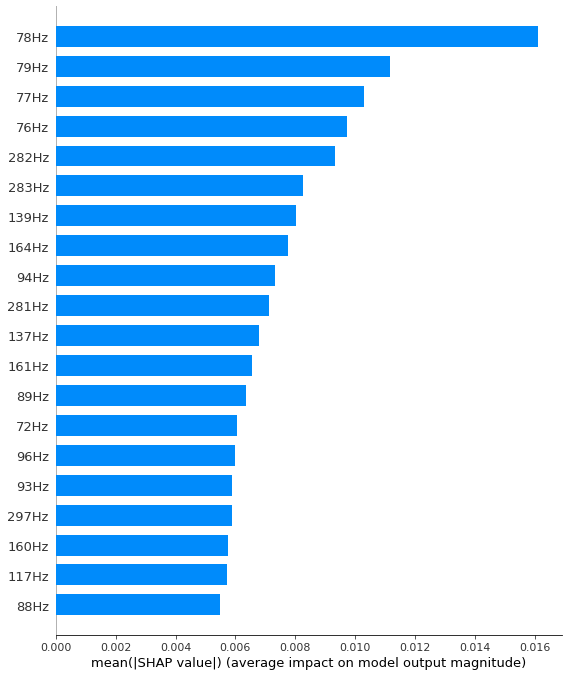

In [34]:
shap.summary_plot(shap_values[0], X_test, plot_type="bar", sort=True)

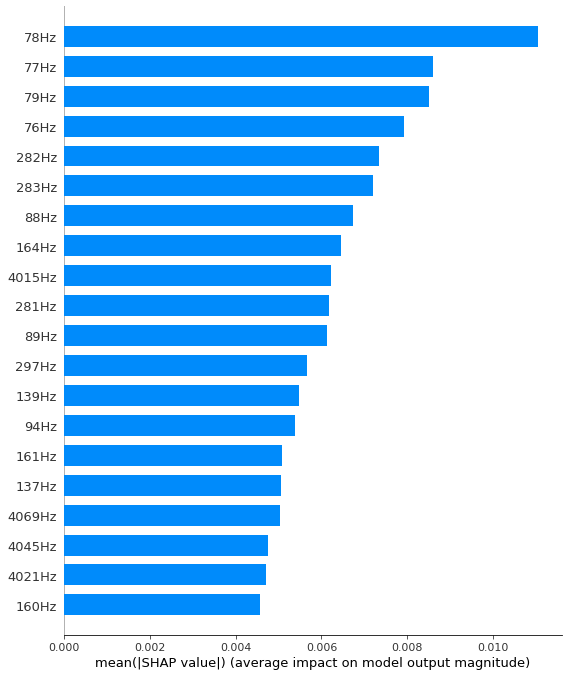

In [35]:
shap.summary_plot(shap_values[1], X_test, plot_type="bar", sort=True)

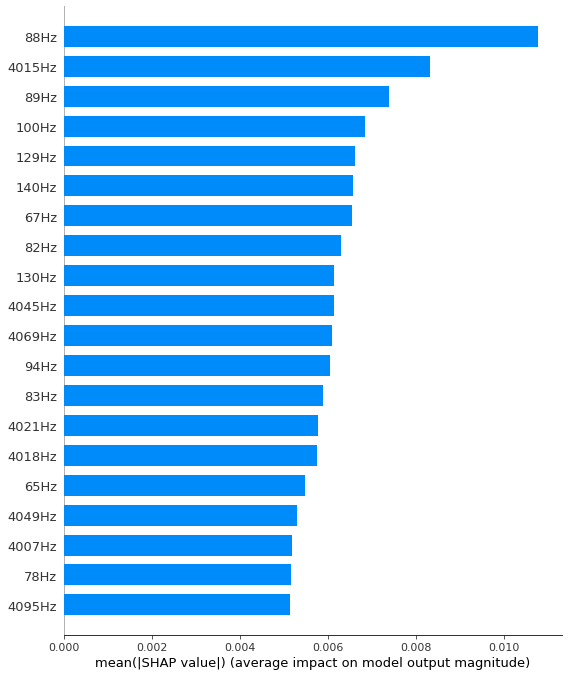

In [36]:
shap.summary_plot(shap_values[2], X_test, plot_type="bar", sort=True)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


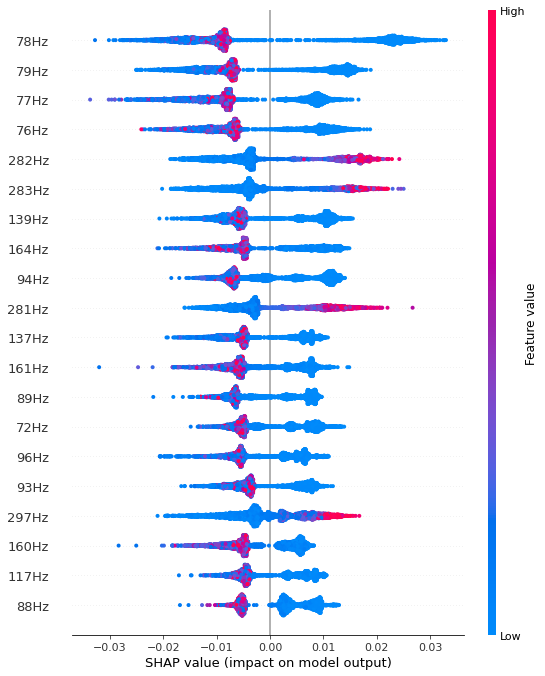

In [37]:
shap.summary_plot(shap_values[0], X_test)

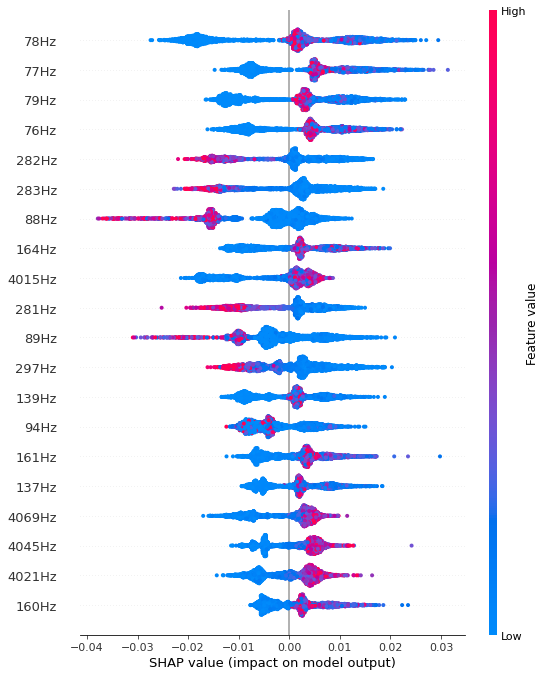

In [38]:
shap.summary_plot(shap_values[1], X_test)

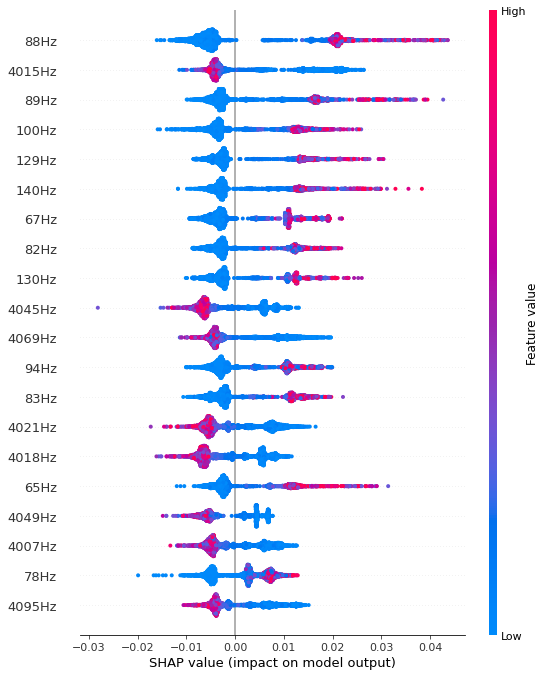

In [39]:
shap.summary_plot(shap_values[2], X_test)

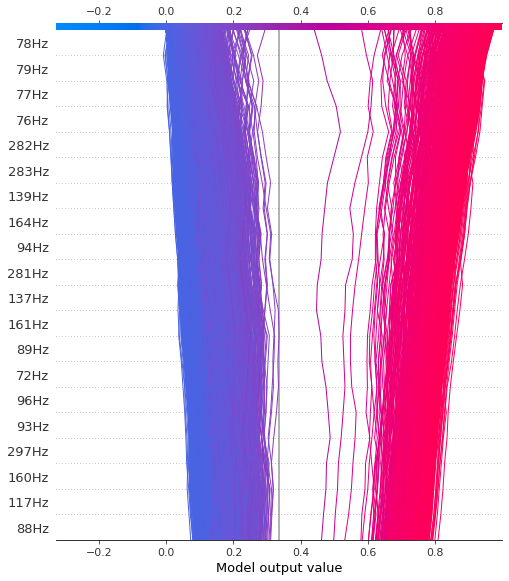

In [40]:
shap.decision_plot(expected_value[0], shap_values[0], X_test, ignore_warnings=True)

In [41]:
number_show = 10
shap_values_summary = explainer.shap_values(X_train.iloc[:number_show])
shap.force_plot(expected_value[0], shap_values_summary[0], X_test.iloc[:number_show])

In [42]:
X_test.head(10)

1Hz       2Hz       3Hz       4Hz       5Hz       6Hz       7Hz  \
217    0.884615  0.256707  0.214692  0.441903  0.317109  0.523912  0.132981   
3501   1.148148  0.714888  0.942489  0.543436  0.207399  1.351707  0.654297   
17236  3.490127  3.272107  2.735113  2.014695  1.413600  1.653164  2.280454   
17225  1.040652  1.051998  1.059286  1.053767  1.053508  1.050516  1.051578   
4935   0.518519  0.824382  0.937471  1.030286  0.481099  0.623019  0.520533   
563    0.190000  0.513858  0.064496  0.547879  0.304822  0.448364  0.639134   
12302  0.048656  0.050207  0.040273  0.049697  0.051204  0.050550  0.048800   
2923   0.648148  0.762806  1.084198  0.913969  0.215484  0.798839  1.034034   
7017   1.433962  0.304997  1.438117  1.195098  0.582862  1.077245  1.396815   
4202   0.875000  0.981167  0.718840  1.024475  0.415547  0.495030  0.865603   

            8Hz       9Hz      10Hz  ...    4087Hz    4088Hz    4089Hz  \
217    0.496762  0.731486  0.237321  ...  0.939465  0.461710  0.702599   
3501   0.822369  0.507245  0.928665  ...  0.429289  0.298521  0.530506   
17236  3.006116  3.303297  3.275004  ...  0.262861  0.262792  0.262730   
17225  1.058857  1.048057  1.050458  ...  0.055702  0.055718  0.055740   
4935   0.744345  0.738377  0.614733  ...  0.984044  0.281061  0.747112   
563    0.052340  0.153191  0.114676  ...  0.652553  0.843396  0.045474   
12302  0.048744  0.048269  0.051939  ...  0.022538  0.022534  0.022544   
2923   0.960355  0.315890  0.602842  ...  0.342540  0.670420  0.809758   
7017   1.290445  1.124560  1.374658  ...  1.339965  0.244193  0.341283   
4202   0.802936  1.114068  1.018720  ...  0.894606  0.294718  0.057849   

         4090Hz    4091Hz    4092Hz    4093Hz    4094Hz    4095Hz    4096Hz  
217    0.515603  0.371220  0.693900  1.549056  0.237525  1.050175  1.034953  
3501   0.306090  0.387760  0.339200  0.608436  0.300683  0.335056  0.709531  
17236  0.262705  0.262687  0.262647  0.262618  0.262599  0.262585  0.262579  
17225  0.055742  0.055757  0.055759  0.055769  0.055772  0.055775  0.055779  
4935   0.437990  0.852810  0.905265  0.984670  1.203909  0.294765  0.319462  
563    0.346998  0.683475  0.410055  0.652483  0.713048  0.637395  0.542783  
12302  0.022548  0.022546  0.022548  0.022551  0.022551  0.022551  0.022554  
2923   0.249950  0.203728  1.312863  0.335096  0.225739  0.247345  0.696566  
7017   0.916994  0.779307  0.587285  0.560810  0.735308  1.120033  0.488148  
4202   0.507554  1.123163  0.334757  0.557755  0.352113  0.341881  1.080785  

[10 rows x 4096 columns]

In [43]:
idx = 563  # 5 on test set
example = X.iloc[idx,:]
example

1Hz       0.190000
2Hz       0.513858
3Hz       0.064496
4Hz       0.547879
5Hz       0.304822
            ...   
4092Hz    0.410055
4093Hz    0.652483
4094Hz    0.713048
4095Hz    0.637395
4096Hz    0.542783
Name: 563, Length: 4096, dtype: float64

In [44]:
idx = 563
example = X.iloc[idx,:]
example_df = X.loc[idx:idx]
model_predict_proba = model.predict_proba(example_df)[0]
model_predict_no = np.argmax(model_predict_proba)
print('{}号的真实标签是 {} ，模型预测为 {} ，完整结果为 {}'.format(idx, y_test[idx], model_predict_no, model_predict_proba))

563号的真实标签是 0 ，模型预测为 0 ，完整结果为 [0.92963191 0.05871692 0.01165118]


In [45]:
no = 5
selection = np.zeros((len(X_test)))
selection[no] = 1
selection = selection > 0

In [46]:
shap_values_example = explainer.shap_values(example)

force_plot = shap.force_plot(expected_value[0], shap_values_example[0], example)
output_file = os.path.join(HOST_path, "IDB_drilling_signal/shap_force_plot0.html") 
shap.save_html(output_file, force_plot)

shap.force_plot(expected_value[0], shap_values_example[0], example)

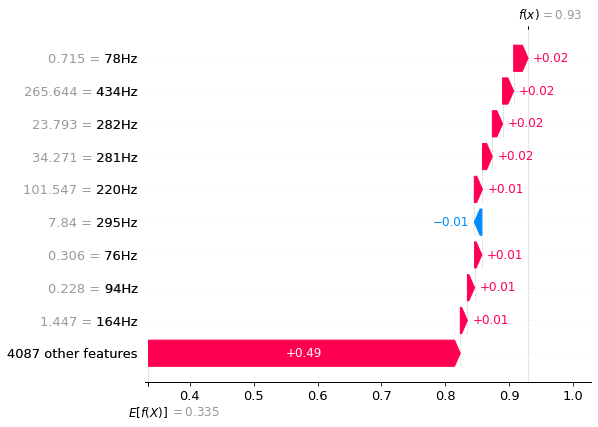

<Figure size 432x288 with 0 Axes>

In [47]:
shap.waterfall_plot(shap.Explanation(values=shap_values_example[0], 
                                     base_values=expected_value[0], 
                                     data=example))

output_file = os.path.join(HOST_path, "IDB_drilling_signal/waterfall_plot0.png") 
plt.savefig(output_file, dpi=300)

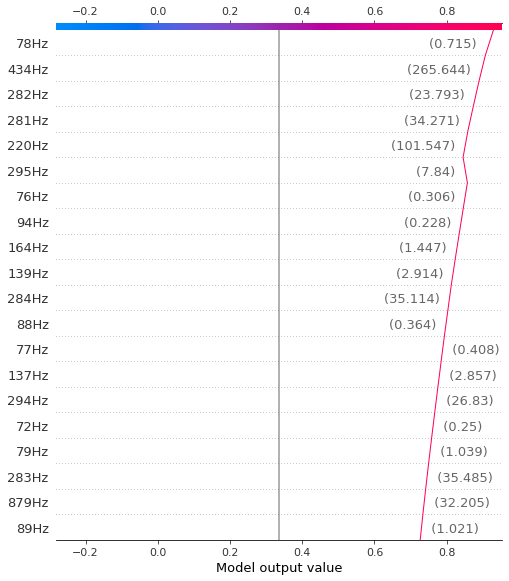

<Figure size 432x288 with 0 Axes>

In [48]:
shap.decision_plot(expected_value[0], shap_values[0][selection], X_test[selection])

output_file = os.path.join(HOST_path, "IDB_drilling_signal/decision_plot0.png") 
plt.savefig(output_file, dpi=300)

In [49]:
shap_values_example = explainer.shap_values(example)

force_plot = shap.force_plot(expected_value[1], shap_values_example[1], example)
output_file = os.path.join(HOST_path, "IDB_drilling_signal/shap_force_plot1.html") 
shap.save_html(output_file, force_plot)

shap.force_plot(expected_value[1], shap_values_example[1], example)

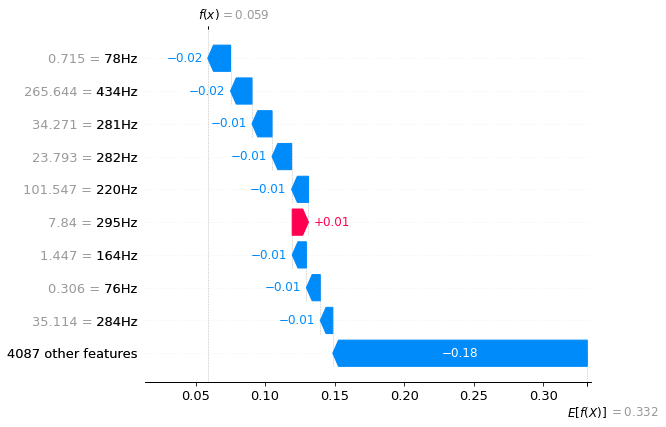

<Figure size 432x288 with 0 Axes>

In [50]:
shap.waterfall_plot(shap.Explanation(values=shap_values_example[1], 
                                     base_values=expected_value[1], 
                                     data=example))

output_file = os.path.join(HOST_path, "IDB_drilling_signal/waterfall_plot1.png") 
plt.savefig(output_file, dpi=300)

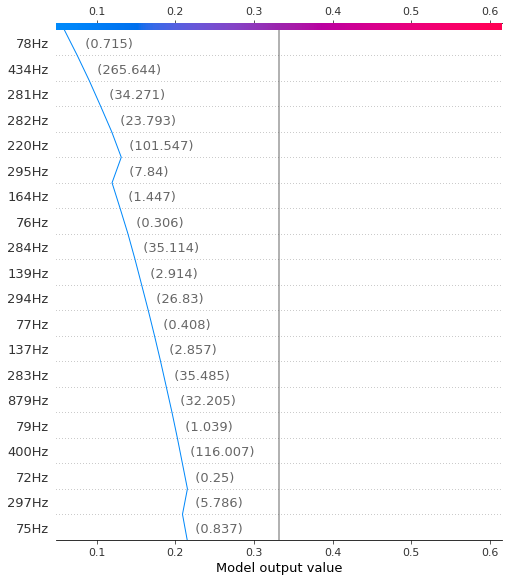

<Figure size 432x288 with 0 Axes>

In [51]:
shap.decision_plot(expected_value[1], shap_values[1][selection], X_test[selection])

output_file = os.path.join(HOST_path, "IDB_drilling_signal/decision_plot1.png") 
plt.savefig(output_file, dpi=300)

In [52]:
shap_values_example = explainer.shap_values(example)

force_plot = shap.force_plot(expected_value[2], shap_values_example[2], example)
output_file = os.path.join(HOST_path, "IDB_drilling_signal/shap_force_plot2.html") 
shap.save_html(output_file, force_plot)

shap.force_plot(expected_value[2], shap_values_example[2], example)

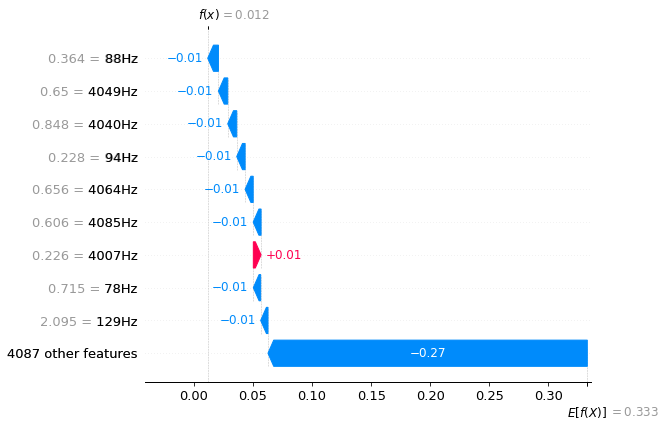

<Figure size 432x288 with 0 Axes>

In [53]:
shap.waterfall_plot(shap.Explanation(values=shap_values_example[2], 
                                     base_values=expected_value[2], 
                                     data=example))

output_file = os.path.join(HOST_path, "IDB_drilling_signal/waterfall_plot2.png") 
plt.savefig(output_file, dpi=300)

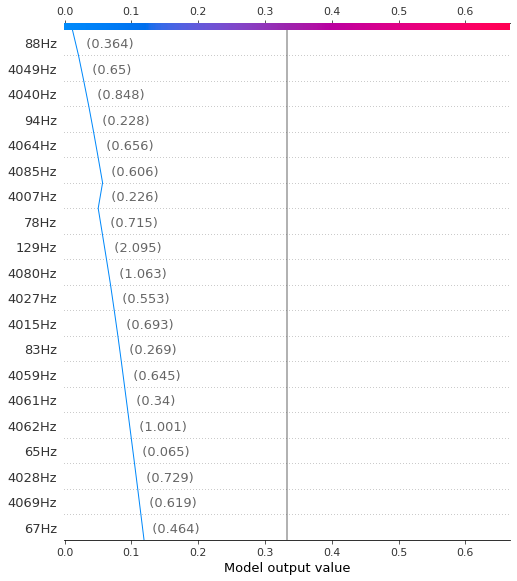

<Figure size 432x288 with 0 Axes>

In [54]:
shap.decision_plot(expected_value[2], shap_values[2][selection], X_test[selection])

output_file = os.path.join(HOST_path, "IDB_drilling_signal/decision_plot2.png") 
plt.savefig(output_file, dpi=300)

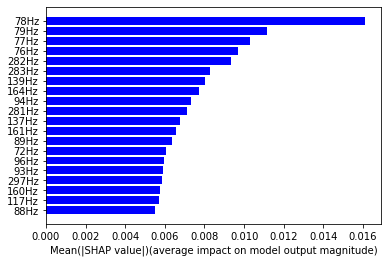

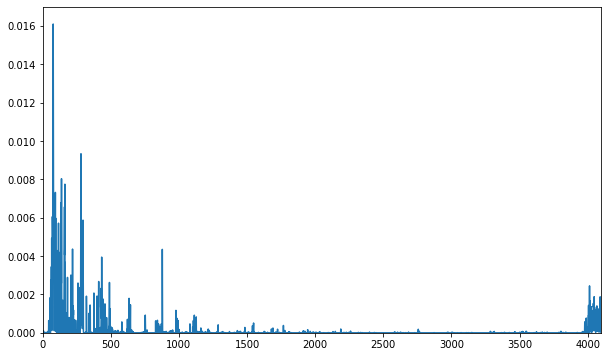

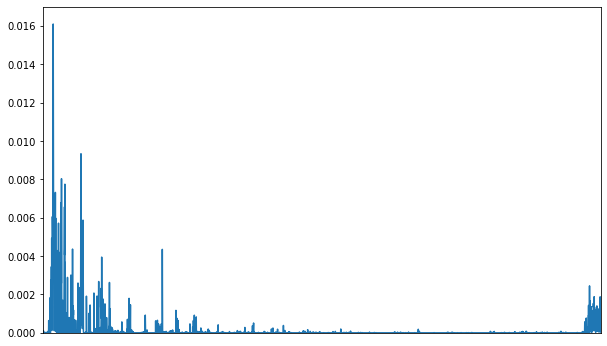

In [74]:
shaps = shap_values[0]
shaps_mean = np.abs(shaps).mean(axis=0)
feature_names = df.drop('type',axis=1).columns

sorted_indices = np.argsort(shaps_mean)[::-1]
sorted_features = feature_names[sorted_indices] 
sorted_shaps_mean = shaps_mean[sorted_indices]
max_display = 20  
selected_features = sorted_features[:max_display]
selected_shaps_mean = sorted_shaps_mean[:max_display]
fig, ax = plt.subplots()
ax.barh(np.arange(max_display), selected_shaps_mean, align='center', color='b')
ax.set_yticks(np.arange(max_display))
ax.set_yticklabels(selected_features)
ax.invert_yaxis()
ax.set_xlabel('Mean(|SHAP value|)(average impact on model output magnitude)')
# ax.set_xlabel('Mean Absolute SHAP Value')
# ax.set_title('Summary Plot of SHAP Values')
plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_0_20.png"), dpi=300)
plt.show()

plt.figure(figsize=(10,6))
plt.xlim(0,4096)
plt.ylim(0,0.017)
ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(shaps_mean)
# plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_0_all.png"), dpi=300)
plt.show()

plt.figure(figsize=(10,6))
plt.xlim(0,4096)
plt.ylim(0,0.017)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(shaps_mean)
plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_0_all.png"), dpi=300)
plt.show()

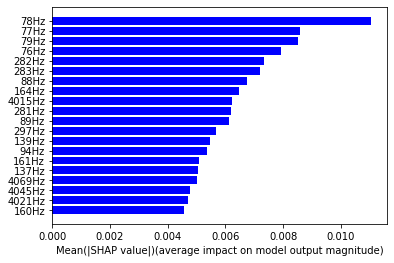

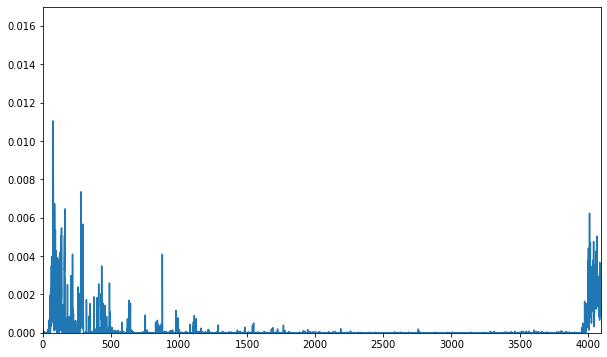

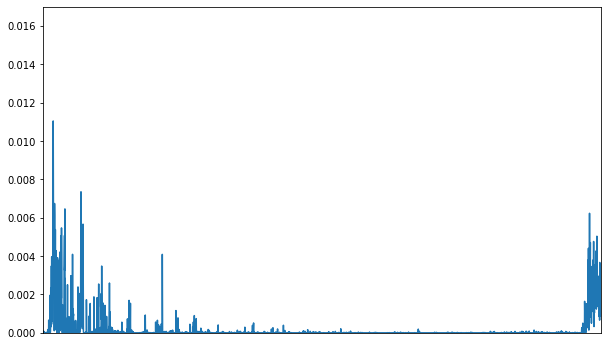

In [75]:
shaps = shap_values[1]
shaps_mean = np.abs(shaps).mean(axis=0)
feature_names = df.drop('type',axis=1).columns

sorted_indices = np.argsort(shaps_mean)[::-1]
sorted_features = feature_names[sorted_indices] 
sorted_shaps_mean = shaps_mean[sorted_indices]
max_display = 20  
selected_features = sorted_features[:max_display]
selected_shaps_mean = sorted_shaps_mean[:max_display]
fig, ax = plt.subplots()
ax.barh(np.arange(max_display), selected_shaps_mean, align='center', color='b')
ax.set_yticks(np.arange(max_display))
ax.set_yticklabels(selected_features)
ax.invert_yaxis()
ax.set_xlabel('Mean(|SHAP value|)(average impact on model output magnitude)')
# ax.set_xlabel('Mean Absolute SHAP Value')
# ax.set_title('Summary Plot of SHAP Values')
plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_1_20.png"), dpi=300)
plt.show()

plt.figure(figsize=(10,6))
plt.xlim(0,4096)
plt.ylim(0,0.017)
ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(shaps_mean)
# plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_1_all.png"), dpi=300)
plt.show()

plt.figure(figsize=(10,6))
plt.xlim(0,4096)
plt.ylim(0,0.017)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(shaps_mean)
plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_1_all.png"), dpi=300)
plt.show()

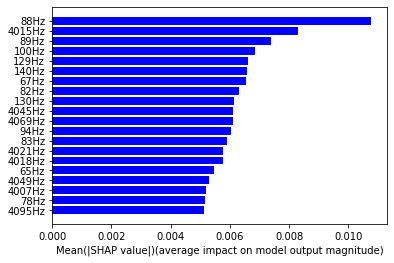

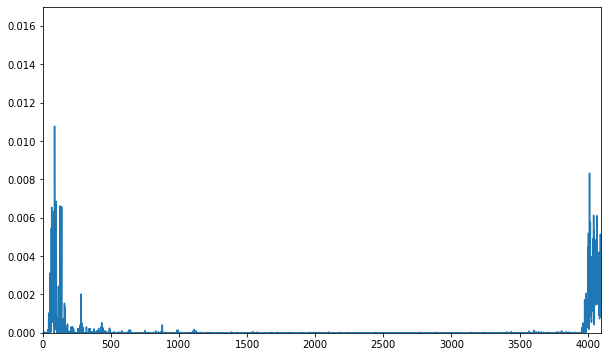

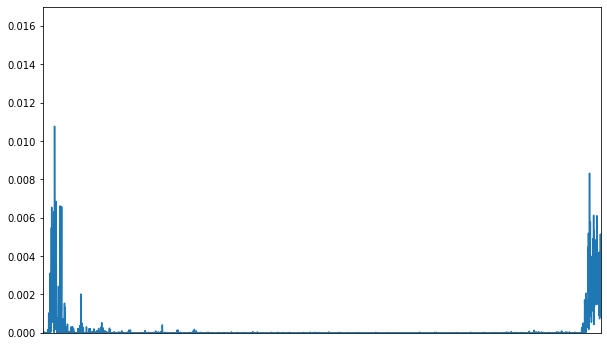

In [76]:
shaps = shap_values[2]
shaps_mean = np.abs(shaps).mean(axis=0)
feature_names = df.drop('type',axis=1).columns

sorted_indices = np.argsort(shaps_mean)[::-1]
sorted_features = feature_names[sorted_indices] 
sorted_shaps_mean = shaps_mean[sorted_indices]
max_display = 20  
selected_features = sorted_features[:max_display]
selected_shaps_mean = sorted_shaps_mean[:max_display]
fig, ax = plt.subplots()
ax.barh(np.arange(max_display), selected_shaps_mean, align='center', color='b')
ax.set_yticks(np.arange(max_display))
ax.set_yticklabels(selected_features)
ax.invert_yaxis()
ax.set_xlabel('Mean(|SHAP value|)(average impact on model output magnitude)')
# ax.set_xlabel('Mean Absolute SHAP Value')
# ax.set_title('Summary Plot of SHAP Values')
plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_2_20.png"), dpi=300)
plt.show()

plt.figure(figsize=(10,6))
plt.xlim(0,4096)
plt.ylim(0,0.017)
ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(shaps_mean)
# plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_2_all.png"), dpi=300)
plt.show()

plt.figure(figsize=(10,6))
plt.xlim(0,4096)
plt.ylim(0,0.017)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(shaps_mean)
plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/shap_2_all.png"), dpi=300)
plt.show()

### DL model

#### Make dataset

In [58]:
# X_set = np.expand_dims(X_set, axis=-1)
# Y_set = to_categorical(Y_set, num_classes=num_classes)

# x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

# print("x_train:", x_train.shape)
# print("y_train:", y_train.shape)  
# print("x_test:", x_test.shape)
# print("y_test:", y_test.shape)

#### Make model

In [59]:
# def make_1Dgap():
#     model = Sequential()
#     model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=x_train.shape[1:]))
#     model.add(MaxPooling1D(2))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

# def make_1Ddense():
#     model = Sequential()
#     model.add(Conv1D(64, 7, strides=2, activation='relu', padding='same', input_shape=x_train.shape[1:]))
#     model.add(MaxPooling1D(3, strides=2, padding='same'))
#     model.add(Conv1D(32, 3, activation='relu', padding='same'))
#     model.add(Conv1D(32, 3, activation='relu', padding='same'))
#     model.add(Conv1D(32, 3, activation='relu', padding='same'))
#     model.add(GlobalAveragePooling1D())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

# def make_1Dalex():
#     model = Sequential()
#     model.add(Conv1D(96, 11, strides=4, activation='relu', input_shape=x_train.shape[1:]))  # (227, 1)
#     model.add(MaxPooling1D(pool_size=3, strides=2))
#     model.add(Conv1D(256, 5, activation='relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=2))
#     model.add(Conv1D(384, 3, activation='relu'))
#     model.add(Conv1D(384, 3, activation='relu'))
#     model.add(Conv1D(256, 3, activation='relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=2))
#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

# def make_1Dvgg():
#     model = Sequential()
#     model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=x_train.shape[1:]))
#     model.add(Conv1D(64, 3, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(128, 3, activation='relu', padding='same'))
#     model.add(Conv1D(128, 3, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(256, 3, activation='relu', padding='same'))
#     model.add(Conv1D(256, 3, activation='relu', padding='same'))
#     model.add(Conv1D(256, 3, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(512, 3, activation='relu', padding='same'))
#     model.add(Conv1D(512, 3, activation='relu', padding='same'))
#     model.add(Conv1D(512, 3, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(512, 3, activation='relu', padding='same'))
#     model.add(Conv1D(512, 3, activation='relu', padding='same'))
#     model.add(Conv1D(512, 3, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))  
#     return model


# def make_2Dgap():
#     model = Sequential()
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

# def make_2Ddense():
#     model = Sequential()
#     model.add(Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same', input_shape=x_train.shape[1:]))
#     model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

# def make_2Dalex():
#     model = Sequential()
#     model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=x_train.shape[1:]))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
#     model.add(Conv2D(256, (5, 5), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
#     model.add(Conv2D(384, (3, 3), activation='relu'))
#     model.add(Conv2D(384, (3, 3), activation='relu'))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(num_classes, activation='softmax'))  
#     return model

# def make_2Dvgg():
#     model = Sequential()
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
#     model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D((2, 2), strides=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     return model

# time0 = time.time()
# model = make_2Dalex()
# time1 = time.time()
# model.summary()
# # visualkeras.layered_view(model,legend=True)
# # keras.utils.plot_model(model, show_shapes=True)

#### Complete & Train

In [60]:
# time2 = time.time()
# model.compile(optimizer='adam',                # tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
#               loss='categorical_crossentropy', # loss='binary_crossentropy'
#               metrics=['accuracy',
#                        keras.metrics.AUC(),
#                        keras.metrics.Precision(),
#                        keras.metrics.Recall()])

# callbacks = [
#             #  keras.callbacks.ModelCheckpoint("best_model.hdf5",
#             #                                  monitor="loss",
#             #                                  mode="min",
#             #                                  save_best_only=True),
# #              keras.callbacks.EarlyStopping(monitor="val_loss",
# #                                            mode="min",
# #                                            verbose=1,
# #                                            patience=10,
# #                                            restore_best_weights=True), 
#              keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
#                                                factor=0.2,
#                                                patience=2,
#                                                min_lr=0.000001),
#             # keras.callbacks.TensorBoard(log_dir=os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_logs"),
#             #                             histogram_freq=1,
#             #                             write_graph=True, 
#             #                             write_images=True),
#             ]

# history = model.fit(x_train, y_train,
#                     validation_split=0.2, 
#                     epochs=200, 
#                     batch_size=64, 
#                     callbacks=callbacks, 
#                     shuffle=True)
# time3 = time.time()

#### Show model results

In [61]:
# y_test_true = np.argmax(y_test, axis=1)
# time4 = time.time()
# y_test_pred = np.argmax(model.predict(x_test), axis=1)
# time5 = time.time()
# accuracy = accuracy_score(y_test_true, y_test_pred)
# precision = precision_score(y_test_true, y_test_pred, average='weighted')
# recall = recall_score(y_test_true, y_test_pred, average='weighted')
# f1 = f1_score(y_test_true, y_test_pred, average='weighted')
# classification_report = classification_report(y_test_true, y_test_pred)
# confusion_matrix = confusion_matrix(y_test_true, y_test_pred)
# time6 = time.time()
# print("Train time:", time1-time0+time3-time2)
# print("Predict time:", time5-time4)
# print("Process time:", time6-time5)
# print("Function time:", time6-time4)
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)
# print("\nClassification Report:\n", classification_report)
# print("\nConfusion Matrix:\n", confusion_matrix)

In [62]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # # Define the confusion matrix array
# # confusion_matrix = np.array([[1181,    0,    0],
# #                              [   0, 1243,    0],
# #                              [   0,    0, 1224]])
# # Create a figure and axes
# fig, ax = plt.subplots()
# # Define the font size for the annotations
# annot_font_family = 'Times New Roman'
# annot_font_weight = 'bold'
# annot_font_size = 18
# # Plot the confusion matrix with custom font size for the annotations
# sns.heatmap(confusion_matrix, annot=True, fmt='d', 
#             cmap='Oranges', cbar=False, square=True,
#             xticklabels=False, yticklabels=False,
#             annot_kws={'fontsize': annot_font_size,
#                       #  'fontfamily': annot_font_family,
#                        'fontweight': annot_font_weight}, ax=ax)
# # Remove x-label, y-label, x-tick labels, and y-tick labels
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# # Show the plot
# plt.show()
# plt.savefig('cm.png', dpi=300)

In [63]:
# test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(x_test, y_test)
# print("test_loss: ", test_loss)
# print("test_accuracy: ", test_accuracy)
# print("test_auc: ", test_auc)
# print("test_precision: ", test_precision)
# print("test_recall: ", test_recall)

#### Save model results

In [64]:
# eval_dict = {"y_test_true":y_test_true, "y_test_pred":y_test_pred, "test_loss":test_loss, "test_accuracy":test_accuracy, "test_auc":test_auc, "test_precision":test_precision, "test_recall":test_recall}
# model.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_model.hdf5"))
# np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_history.npy"), history.history)
# np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.npy"), eval_dict)

#### Load model results

In [65]:
# model = load_model(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_model.hdf5"))
# hist = np.load(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_history.npy"), allow_pickle=True).item()
# eval_dict = np.load(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.npy"), allow_pickle=True).item()

#### Plot model results

In [66]:
# def plot_history_metrics(history):
#   total_plots = len(history)
#   cols = total_plots // 2
#   rows = total_plots // cols
#   if total_plots % cols != 0:
#     rows += 1
#   pos = range(1, total_plots + 1)
#   plt.figure(figsize=(15, 10))
#   for i, (key, value) in enumerate(history.items()):
#     plt.subplot(rows, cols, pos[i])
#     plt.plot(range(len(value)), value)
#     plt.title(str(key))
#   plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.png"))
 
# plot_history_metrics(history.history)

## Regression

### Data pre-treatment

In [67]:
# X_set = np.concatenate((S11,S12,S13,S14,S21,S22,S23,S31,S32,S33,S41,S42,S43,S51,S52,S53,S54,S61,S62,S63,S71,S72,S73,S74,S81,S82,S83,S91,S92,S93,S94), axis=0)
# X_set = X_set.reshape((X_set.shape[0], X_set.shape[1], 1))
# S1Y = [0,0,0, 150, 200, 8]
# S2Y = [0,0,0, 250, 250, 10]
# S3Y = [0,0,0, 350, 150, 6]
# S4Y = [0,1,0, 150, 250, 6]
# S5Y = [0,1,0, 250, 150, 8]
# S6Y = [0,1,0, 350, 200, 10]
# S7Y = [0,0,1, 150, 150, 10]
# S8Y = [0,0,1, 250, 200, 6]
# S9Y = [0,0,1, 350, 250, 8]
# S1L = len(S11)+len(S12)+len(S13)+len(S14)
# S2L = len(S21)+len(S22)+len(S23)
# S3L = len(S31)+len(S32)+len(S33)
# S4L = len(S41)+len(S42)+len(S43)
# S5L = len(S51)+len(S52)+len(S53)+len(S54)
# S6L = len(S61)+len(S62)+len(S63)
# S7L = len(S71)+len(S72)+len(S73)+len(S74)
# S8L = len(S81)+len(S82)+len(S83)
# S9L = len(S91)+len(S92)+len(S93)+len(S94)
# S_1 = [S1Y for _ in range(S1L)]
# S_2 = [S2Y for _ in range(S2L)]
# S_3 = [S3Y for _ in range(S3L)]
# S_4 = [S4Y for _ in range(S4L)]
# S_5 = [S5Y for _ in range(S5L)]
# S_6 = [S6Y for _ in range(S6L)]
# S_7 = [S7Y for _ in range(S7L)]
# S_8 = [S8Y for _ in range(S8L)]
# S_9 = [S9Y for _ in range(S9L)]
# Y_set = np.concatenate((S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9), axis=0)
# num_targets = Y_set.shape[1]
# x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.25, random_state=42)

### Model establishment

In [68]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
# from keras.layers import Activation, Dropout, Flatten, Dense

# def make_cnn_model():
#     model = Sequential()
#     model.add(Conv1D(64, 3, input_shape=x_train.shape[1:], padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(64, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(128, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(128, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Flatten())
#     model.add(Dense(256))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(4096))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(num_targets, activation='linear'))
#     return model

# model = make_cnn_model()
# model.summary()
# # keras.utils.plot_model(model, show_shapes=True)

### Complete & Train

In [69]:
# model.compile(optimizer='adam', loss='mse')

# callbacks = [
#             #  keras.callbacks.ModelCheckpoint("best_model.hdf5",
#             #                                  monitor="loss",
#             #                                  mode="min",
#             #                                  save_best_only=True),
#              keras.callbacks.EarlyStopping(monitor="val_loss",
#                                            mode="min",
#                                            verbose=1,
#                                            patience=10,
#                                            restore_best_weights=True), 
#              keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
#                                                factor=0.2,
#                                                patience=2,
#                                                min_lr=0.000001),
#             # keras.callbacks.TensorBoard(log_dir=os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_logs"),
#             #                             histogram_freq=1,
#             #                             write_graph=True, 
#             #                             write_images=True),
#             ]

# history = model.fit(x_train, y_train,
#                     validation_split=0.2, 
#                     epochs=200, 
#                     batch_size=32, 
#                     # callbacks=callbacks, 
#                     shuffle=True)

### Show model results

In [70]:
# y_test_true = y_test
# y_test_pred = model.predict(x_test)
# test_loss = model.evaluate(x_test, y_test)

### Save model results

In [71]:
# eval_dict = {"y_test_true":y_test_true, "y_test_pred":y_test_pred, "test_loss":test_loss}

# model.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_model.hdf5"))
# np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_history.npy"), history.history)
# np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_evaluation.npy"), eval_dict)

### Load model results

In [72]:
# from keras.models import load_model

# model = load_model("/home/svu/e1097232/IDB_drilling_signal/outputs/R_model.hdf5")
# hist = np.load("/home/svu/e1097232/IDB_drilling_signal/outputs/R_history.npy", allow_pickle=True)
# eval_dict = np.load("/home/svu/e1097232/IDB_drilling_signal/outputs/R_evaluation.npy", allow_pickle=True)

### Plot model results

In [73]:
# # Plot Loss-Epoch
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train set', 'Test set'], loc='upper left')
# plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_loss.png"))
# plt.show()